In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split,  GridSearchCV, TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge


In [4]:
set1 = pd.read_csv('../Data/SET_main.csv')
macro = pd.read_csv('../Data/macro_data.csv')

In [27]:
macro

,Interest_Rate,GDP,Unemployment,Inflation_x
Date,,,,
2012-10-01,NaN,16420.419,NaN,NaN
2012-12-01,0.16,16420.419,7.9,231.221
2013-01-01,0.14,16648.189,8.0,231.679
2013-02-01,0.15,16648.189,7.7,232.937
2013-03-01,0.14,16648.189,7.5,232.282
...,...,...,...,...
2024-07-01,5.33,29354.321,4.3,313.534
2024-08-01,5.33,29354.321,4.2,314.121
2024-09-01,5.13,29354.321,4.1,314.686


In [5]:
yrs_5 = round(set1.shape[0]/2)
set1 = set1[-yrs_5:]
set1

,Date,ADVANC.BK,AOT.BK,BBL.BK,BDMS.BK,BH.BK,CPALL.BK,CPF.BK,CPN.BK,DELTA.BK,...,INTUCH.BK,IVL.BK,KBANK.BK,KTB.BK,MINT.BK,PTT.BK,PTTEP.BK,SCC.BK,TRUE.BK,TTB.BK
1331,2019-06-18,161.651642,65.409073,164.686691,22.900856,152.155060,78.473831,24.904963,69.404030,6.022193,...,46.055683,40.216579,158.519485,15.603138,37.345432,36.472263,96.724503,386.370758,4.947053,1.423396
1332,2019-06-19,164.900955,70.939987,165.510162,22.680655,151.708847,78.473831,24.904963,70.323288,6.305590,...,46.055683,41.067722,160.605301,15.764828,37.821171,36.856182,97.840561,391.388580,5.180404,1.423396
1333,2019-06-20,165.713272,71.420937,167.156998,22.680655,152.155060,79.172401,24.904963,70.553101,6.400056,...,46.636215,41.280510,161.439606,15.683984,37.583302,37.432056,100.444664,393.061218,5.273745,1.423396
1334,2019-06-21,167.337891,71.661407,164.686691,22.460453,151.708847,79.638130,24.468033,70.093475,6.470905,...,46.442699,40.642147,160.188126,15.683984,37.583302,37.624020,100.444664,394.733765,5.180404,1.430549
1335,2019-06-24,166.525574,72.623306,164.686691,22.460453,152.155060,79.172401,24.249565,69.633835,6.352823,...,47.216755,40.642147,158.936646,15.764828,37.583302,37.624020,101.188698,391.388580,5.180404,1.416243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2024-12-03,296.000000,61.209999,150.500000,26.000000,212.000000,63.750000,24.200001,60.500000,151.000000,...,102.500000,24.600000,153.500000,20.299999,27.750000,32.250000,128.500000,184.000000,11.900000,1.790000
2658,2024-12-04,289.000000,61.500000,151.500000,25.750000,211.000000,64.000000,24.100000,60.500000,151.000000,...,100.000000,24.500000,155.000000,20.600000,28.000000,32.250000,128.000000,183.000000,12.100000,1.780000
2659,2024-12-06,295.000000,61.000000,152.000000,25.500000,210.000000,63.000000,24.100000,60.250000,150.500000,...,102.500000,25.250000,156.000000,20.700001,27.500000,32.250000,128.000000,183.500000,11.800000,1.830000
2660,2024-12-09,295.000000,60.500000,153.000000,25.250000,202.000000,62.750000,23.900000,59.750000,152.500000,...,101.500000,25.500000,156.500000,21.500000,27.250000,32.000000,126.500000,179.000000,11.800000,1.830000


In [6]:
macro= macro.set_index('Date')
set1 = set1.set_index('Date')

In [11]:
# Loop through each unique ticker (stock) in the DataFrame
indicator = pd.DataFrame()
for ticker in set1.columns:
    # Calculate SMAs 
    indicator[f'{ticker}_SMA3'] = set1[ticker].rolling(window=3).mean()
    indicator[f'{ticker}_SMA20'] = set1[ticker].rolling(window=20).mean()
    indicator[f'{ticker}_SMA50'] = set1[ticker].rolling(window=50).mean()
    indicator[f'{ticker}_SMA100'] = set1[ticker].rolling(window=100).mean()
    indicator[f'{ticker}_SMA200'] = set1[ticker].rolling(window=200).mean()
    
    # Calculate EMA
    indicator[f'{ticker}_EMA3'] = set1[ticker].ewm(span=3, adjust=False).mean()
    indicator[f'{ticker}_EMA12'] = set1[ticker].ewm(span=12, adjust=False).mean()
    indicator[f'{ticker}_EMA26'] = set1[ticker].ewm(span=26, adjust=False).mean()
    
    # Calculate MACD
    indicator[f'{ticker}_MACD'] = indicator[f'{ticker}_EMA12'] - indicator[f'{ticker}_EMA26']
    
    # Calculate Signal line (9-day EMA of the MACD)
    indicator[f'{ticker}_signal'] = indicator[f'{ticker}_MACD'].ewm(span=9, adjust=False).mean()
    
    # Concatenate each ticker's results into the final indicator DataFrame
    indicator = pd.concat([indicator, set1], axis=1)

In [13]:
indicator = indicator.dropna()

In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Merge all the files that have X-variable (features)
features_df = pd.merge(macro, indicator, on='Date', how='outer')
features_df = features_df.fillna(method='ffill').dropna()

In [17]:
# drop the same column names
features_df = features_df.loc[:, ~features_df.columns.duplicated()]

In [19]:
# Make the rows number the same with target and features files
# set the index to the format Datetime
set1.index = pd.to_datetime(set1.index)
features_df.index = pd.to_datetime(features_df.index)

# Align the two DataFrames by finding the intersection of their indices
common_index = set1.index.intersection(features_df.index)

# Reindex both DataFrames to the common index
set1 = set1.loc[common_index]
features_df = features_df.loc[common_index]

In [21]:
features_df.shape, set1.shape

((1132, 224), (1132, 20))

In [23]:
# define X and y
X = features_df 
y = set1 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Training set shape for ADVANC.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for ADVANC.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for ADVANC.BK: {'alpha': 0.01}
Performance for ADVANC.BK - RMSE: 0.004226279833058807


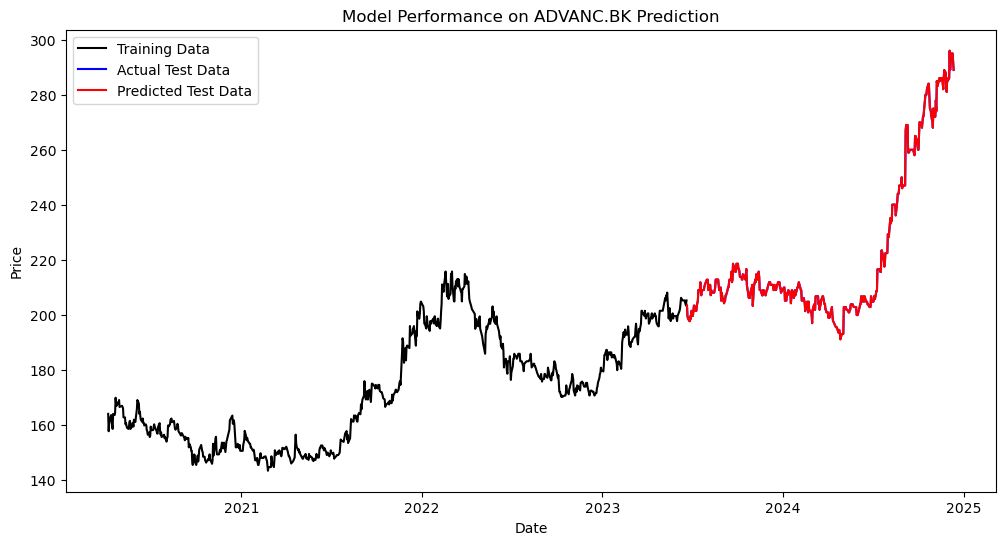

Training set shape for AOT.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for AOT.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for AOT.BK: {'alpha': 0.01}
Performance for AOT.BK - RMSE: 0.002691006822870469


<Figure size 640x480 with 0 Axes>

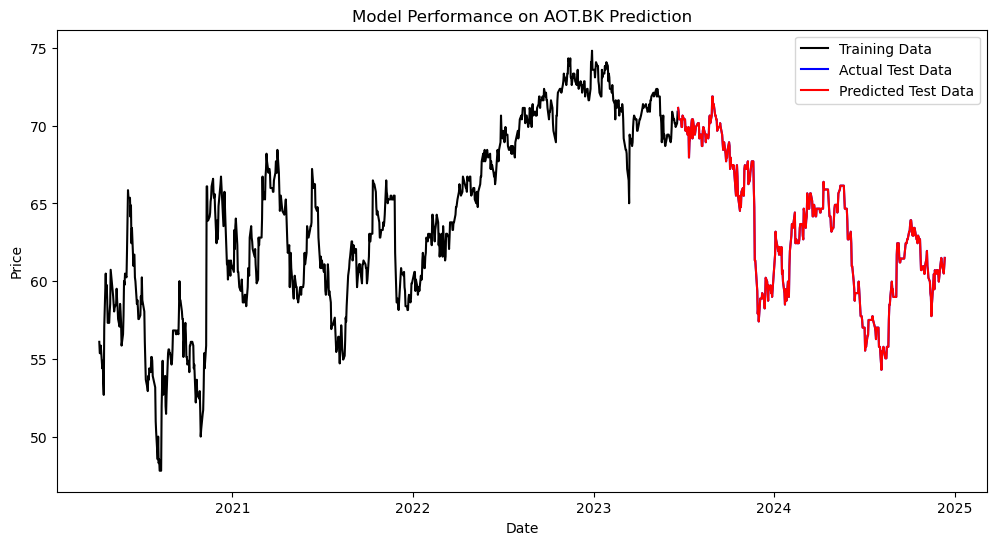

Training set shape for BBL.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for BBL.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for BBL.BK: {'alpha': 0.01}
Performance for BBL.BK - RMSE: 0.001497822519126064


<Figure size 640x480 with 0 Axes>

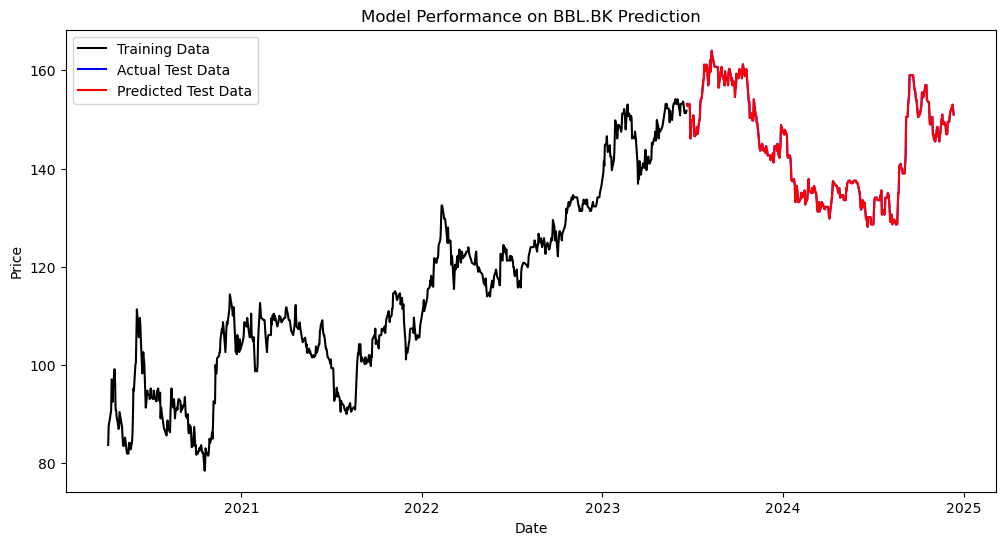

Training set shape for BDMS.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for BDMS.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for BDMS.BK: {'alpha': 0.01}
Performance for BDMS.BK - RMSE: 0.012011860017760034


<Figure size 640x480 with 0 Axes>

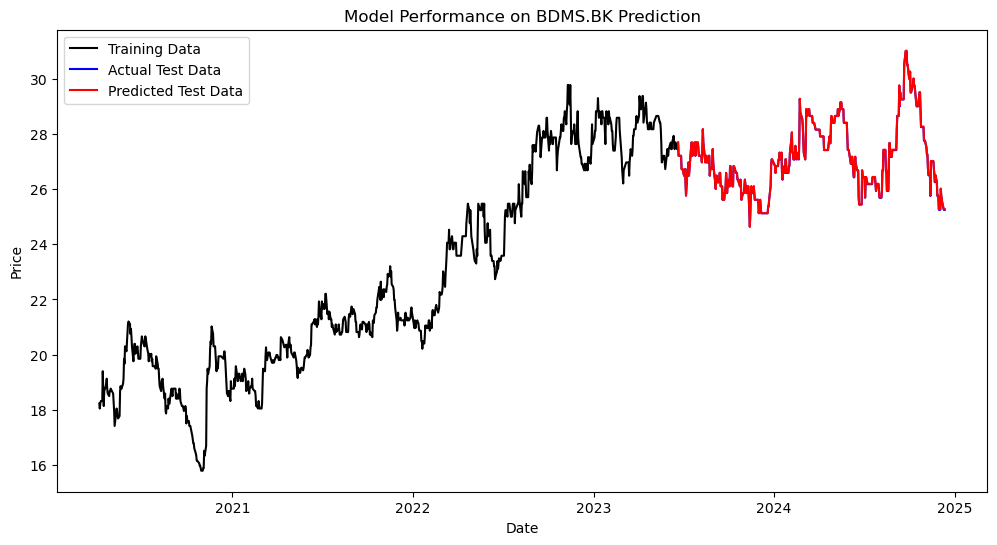

Training set shape for BH.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for BH.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for BH.BK: {'alpha': 0.01}
Performance for BH.BK - RMSE: 0.0009354306087452366


<Figure size 640x480 with 0 Axes>

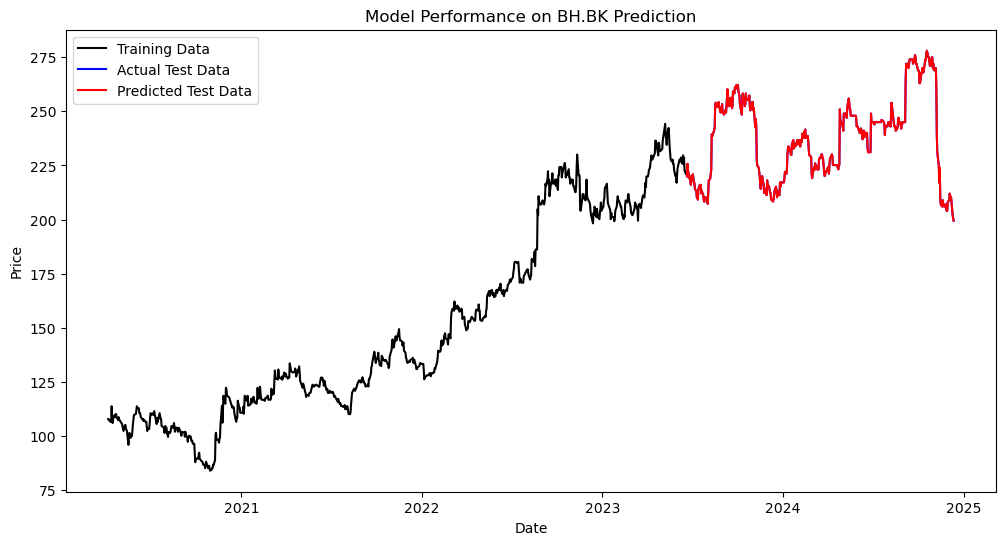

Training set shape for CPALL.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for CPALL.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for CPALL.BK: {'alpha': 0.01}
Performance for CPALL.BK - RMSE: 0.0032115412902515906


<Figure size 640x480 with 0 Axes>

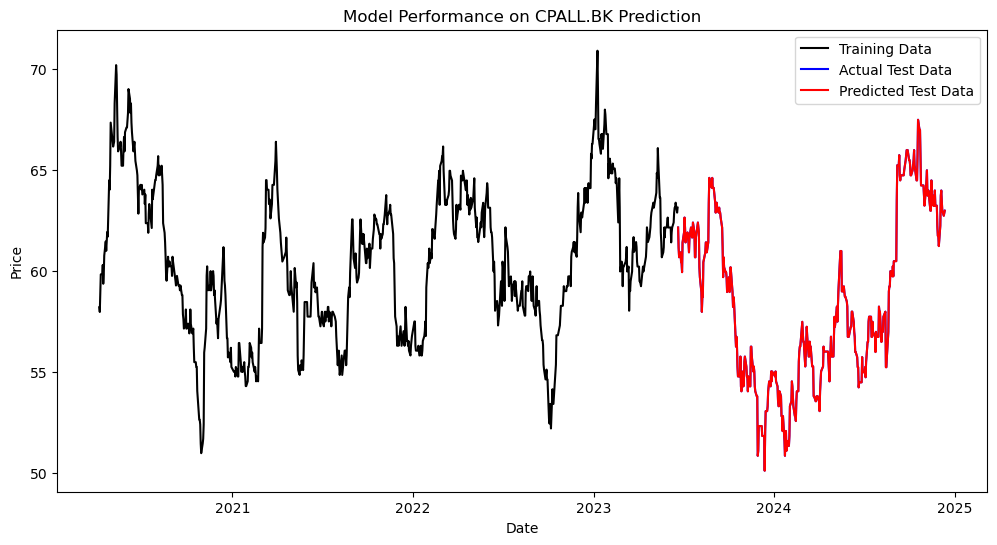

Training set shape for CPF.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for CPF.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for CPF.BK: {'alpha': 0.01}
Performance for CPF.BK - RMSE: 0.00700714601007045


<Figure size 640x480 with 0 Axes>

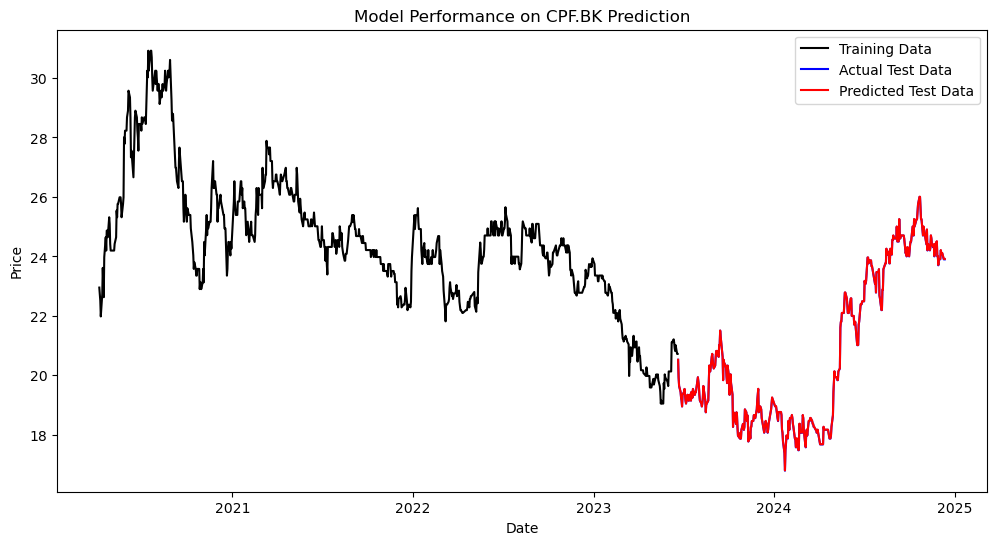

Training set shape for CPN.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for CPN.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for CPN.BK: {'alpha': 0.01}
Performance for CPN.BK - RMSE: 0.00938730507281557


<Figure size 640x480 with 0 Axes>

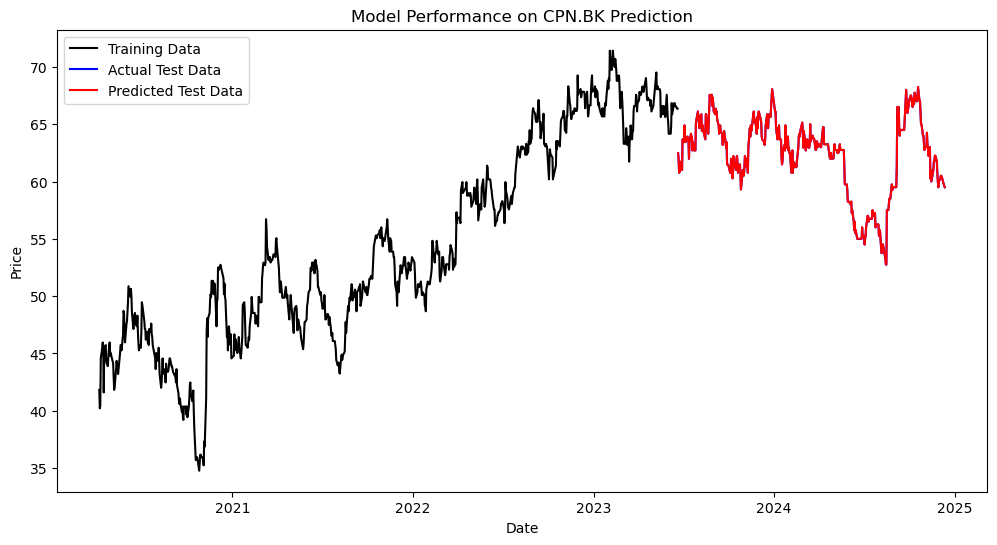

Training set shape for DELTA.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for DELTA.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for DELTA.BK: {'alpha': 0.01}
Performance for DELTA.BK - RMSE: 0.002127609364412906


<Figure size 640x480 with 0 Axes>

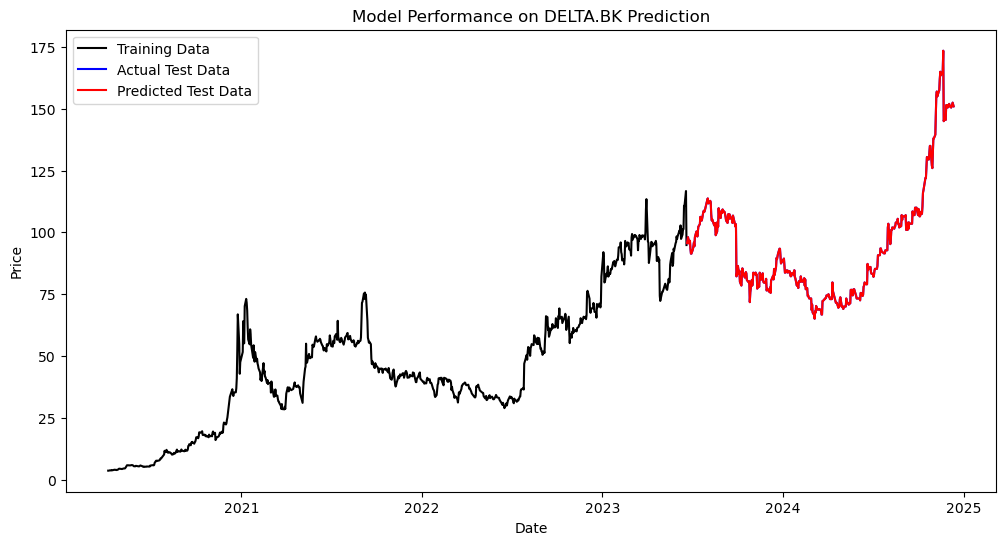

Training set shape for HMPRO.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for HMPRO.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for HMPRO.BK: {'alpha': 0.01}
Performance for HMPRO.BK - RMSE: 0.030201106616165006


<Figure size 640x480 with 0 Axes>

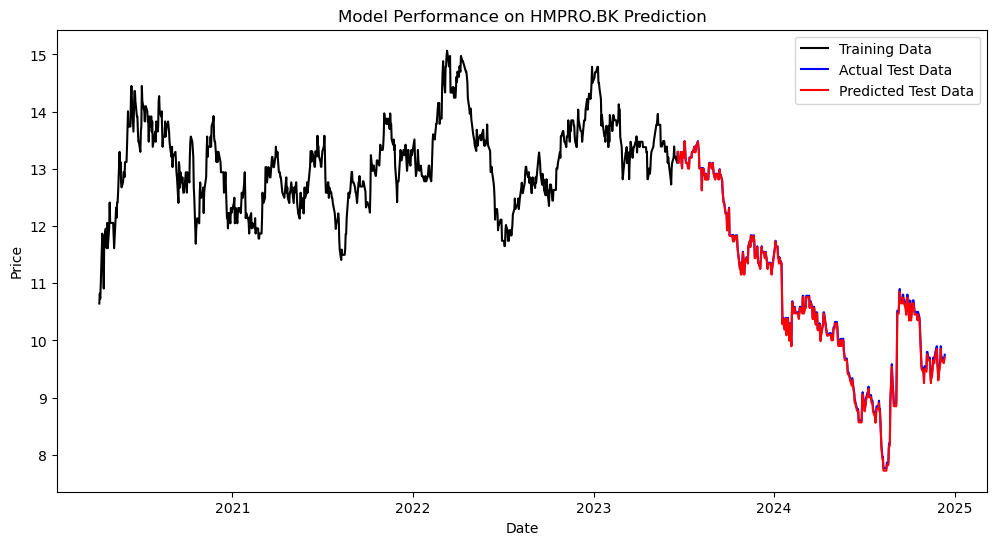

Training set shape for INTUCH.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for INTUCH.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for INTUCH.BK: {'alpha': 0.01}
Performance for INTUCH.BK - RMSE: 0.004409773625649387


<Figure size 640x480 with 0 Axes>

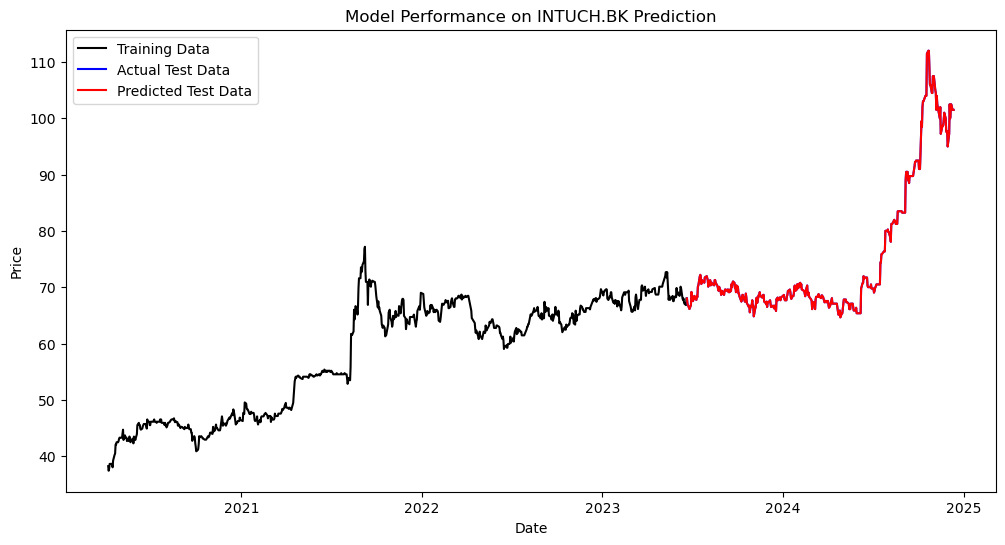

Training set shape for IVL.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for IVL.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for IVL.BK: {'alpha': 0.01}
Performance for IVL.BK - RMSE: 0.004087760010261407


<Figure size 640x480 with 0 Axes>

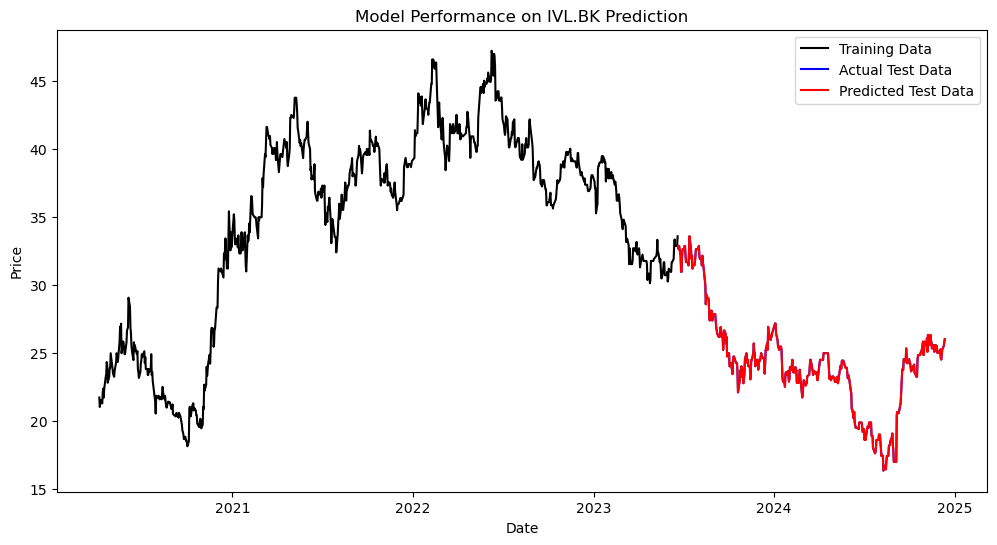

Training set shape for KBANK.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for KBANK.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for KBANK.BK: {'alpha': 0.01}
Performance for KBANK.BK - RMSE: 0.0041044606016717436


<Figure size 640x480 with 0 Axes>

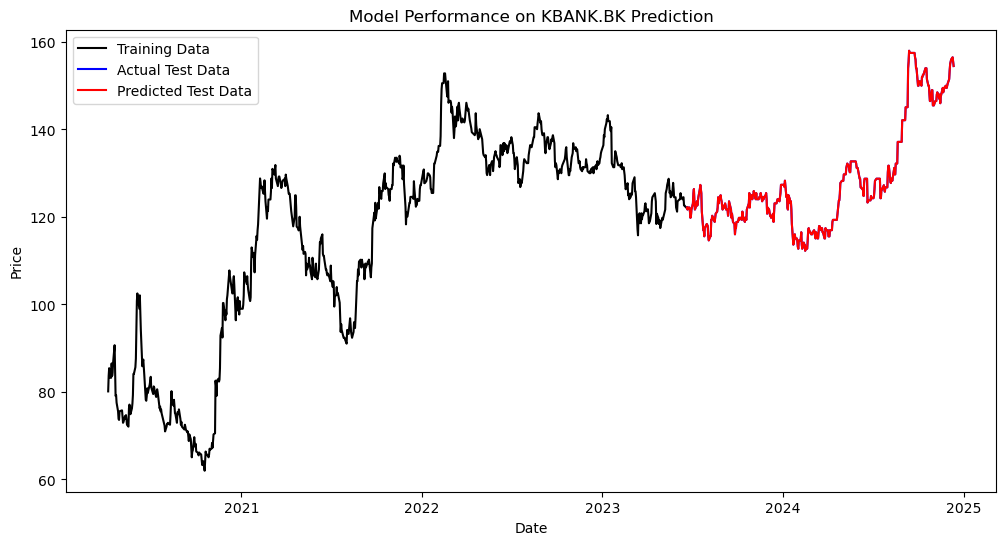

Training set shape for KTB.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for KTB.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for KTB.BK: {'alpha': 0.01}
Performance for KTB.BK - RMSE: 0.008722479647205437


<Figure size 640x480 with 0 Axes>

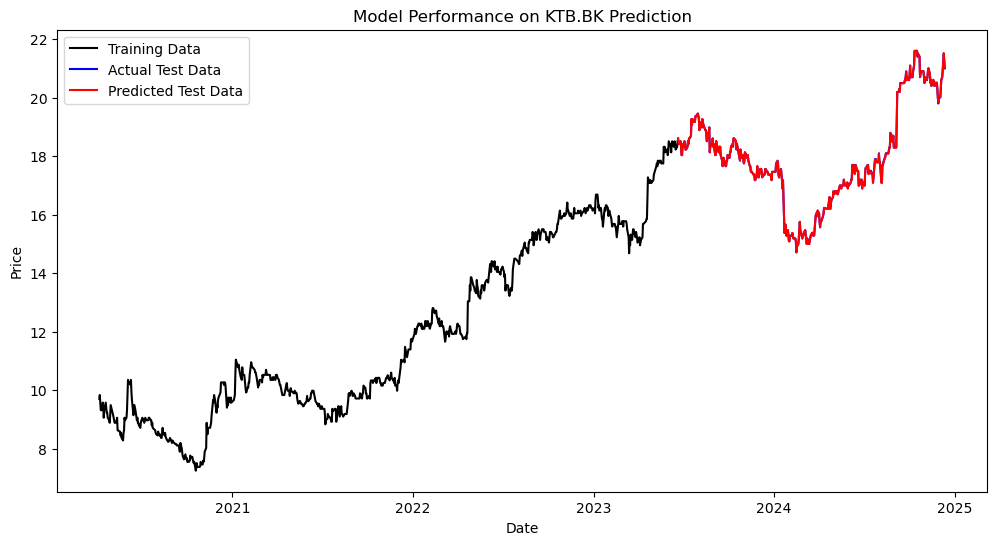

Training set shape for MINT.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for MINT.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for MINT.BK: {'alpha': 0.01}
Performance for MINT.BK - RMSE: 0.007781714715247002


<Figure size 640x480 with 0 Axes>

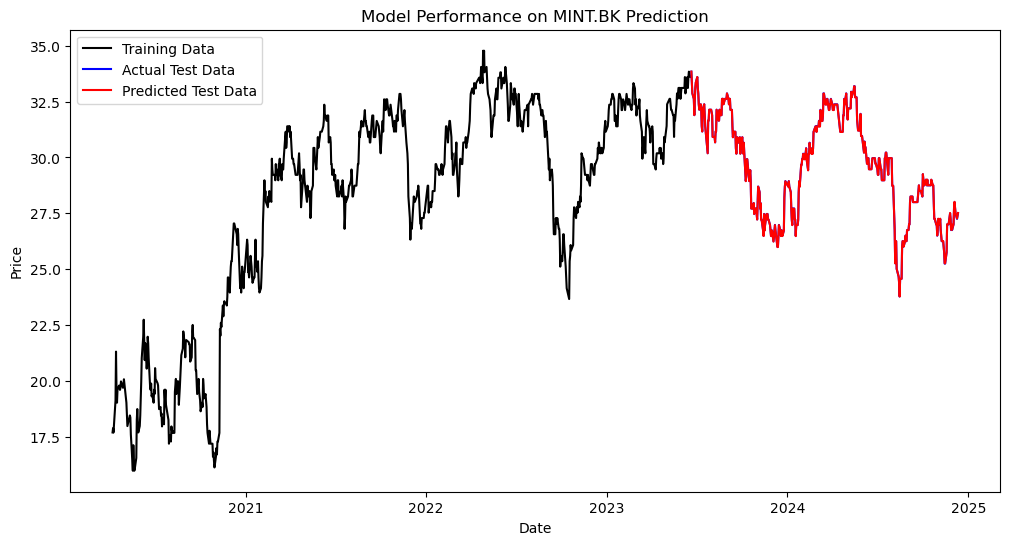

Training set shape for PTT.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for PTT.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for PTT.BK: {'alpha': 0.01}
Performance for PTT.BK - RMSE: 0.013295042062057255


<Figure size 640x480 with 0 Axes>

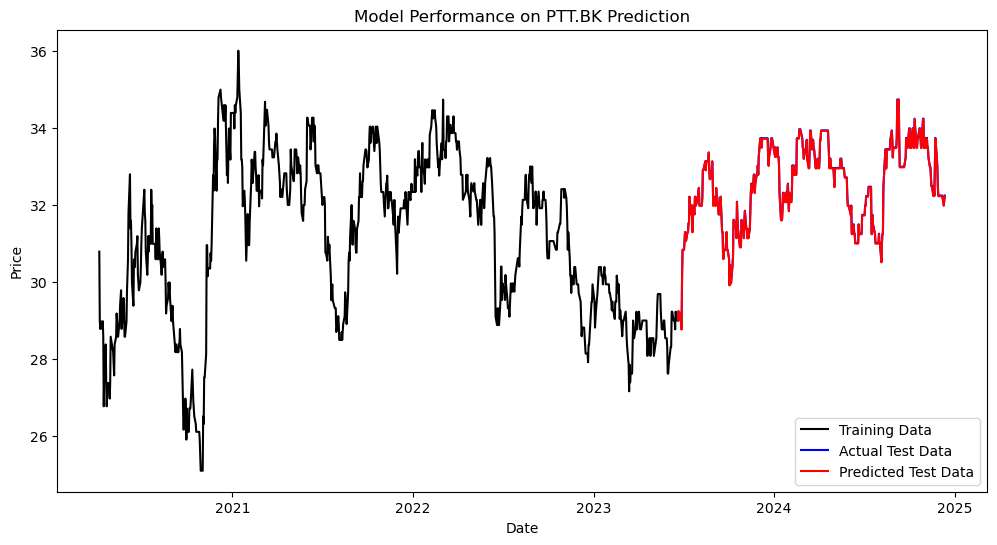

Training set shape for PTTEP.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for PTTEP.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for PTTEP.BK: {'alpha': 0.01}
Performance for PTTEP.BK - RMSE: 0.005470859061612044


<Figure size 640x480 with 0 Axes>

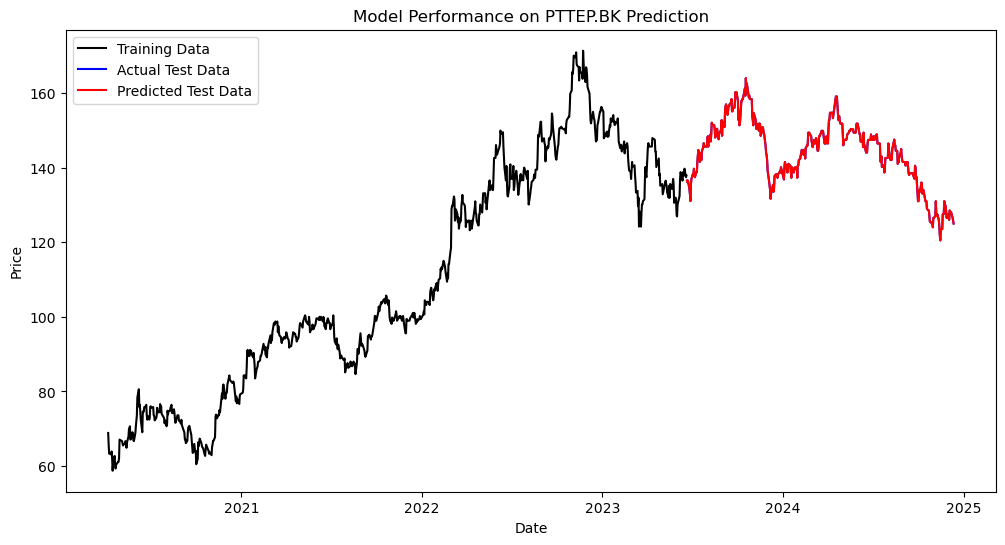

Training set shape for SCC.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for SCC.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for SCC.BK: {'alpha': 0.01}
Performance for SCC.BK - RMSE: 0.000929138321544983


<Figure size 640x480 with 0 Axes>

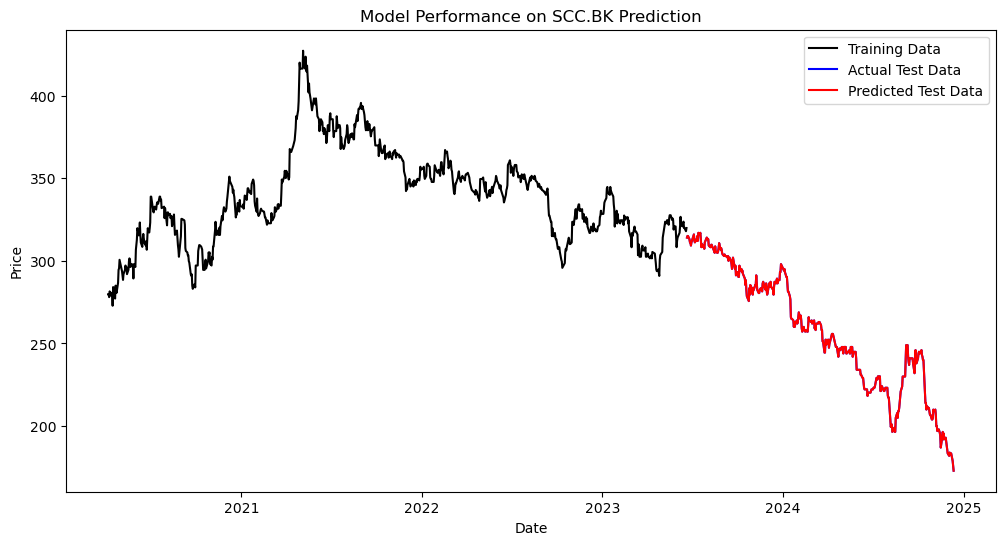

Training set shape for TRUE.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for TRUE.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for TRUE.BK: {'alpha': 0.1}
Performance for TRUE.BK - RMSE: 0.08292859010202618


<Figure size 640x480 with 0 Axes>

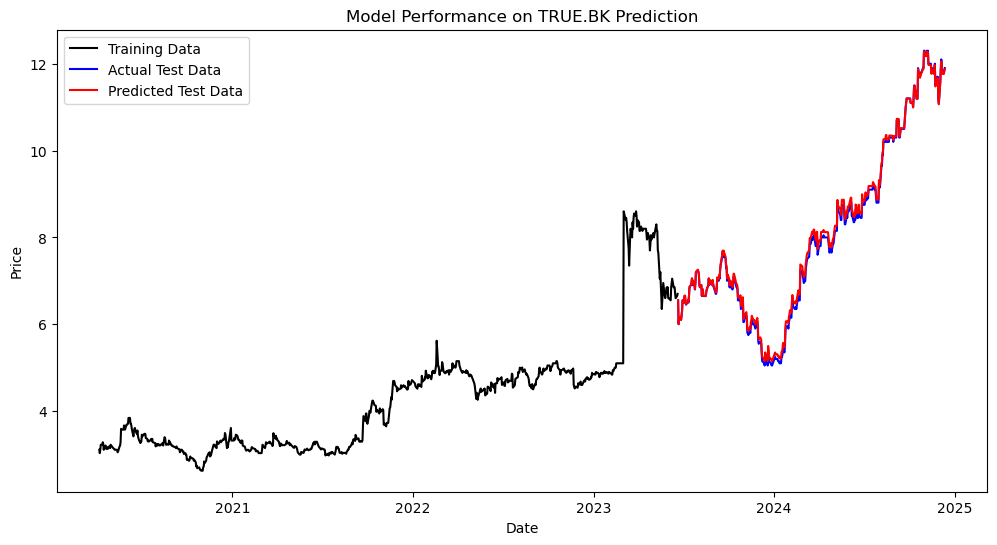

Training set shape for TTB.BK: X_train: (772, 224), y_train: (772,)
Testing set shape for TTB.BK: X_test: (360, 224), y_test: (360,)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters for TTB.BK: {'alpha': 10}
Performance for TTB.BK - RMSE: 0.5129151264963708


<Figure size 640x480 with 0 Axes>

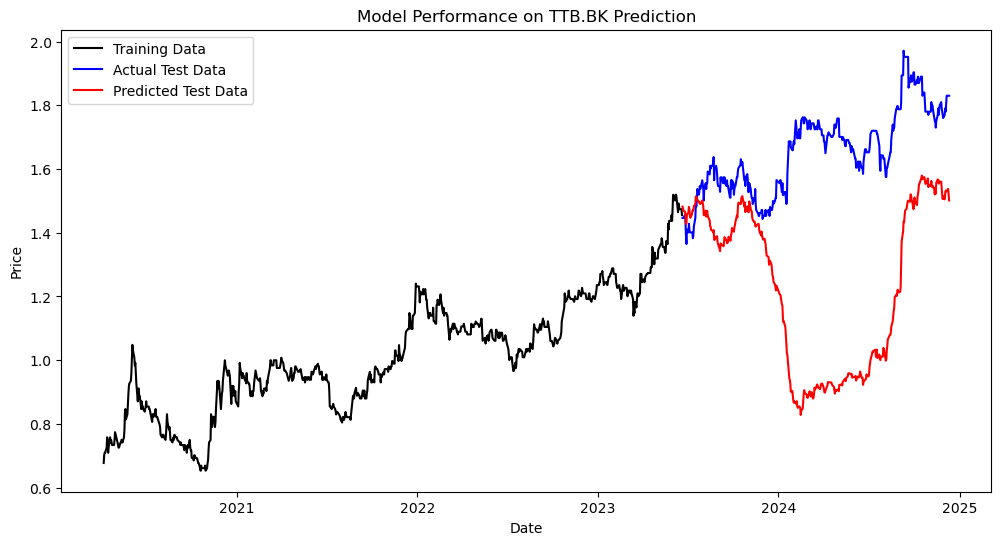

<Figure size 640x480 with 0 Axes>

In [25]:
# Initialize dictionaries to store results
results = {}

# Define the hyperparameter grid for GridSearchCV (alpha for regularization strength)
param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]  # Regularization strength
}

# Fixed test size for the last 360 rows
test_size = 360

# Time Series Split for cross-validation (preserves order)
tscv = TimeSeriesSplit(n_splits=3)

# Loop through each stock in the set1 DataFrame
for stock in set1.columns:
    
    # Prepare the target (stock price) for each stock
    y_stock = set1[stock]  # Stock price for this particular stock
    
    # Define training and testing sets
    X_train = features_df.iloc[:-test_size, :]
    X_test = features_df.iloc[-test_size:, :]
    y_train = y_stock.iloc[:-test_size]
    y_test = y_stock.iloc[-test_size:]
    
    # Print dataset shapes
    print(f"Training set shape for {stock}: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Testing set shape for {stock}: X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Initialize Ridge Regression model
    ridge_reg = Ridge()

    # Perform Grid Search with TimeSeriesSplit cross-validation
    grid_search = GridSearchCV(estimator=ridge_reg, 
                               param_grid=param_grid, 
                               cv=tscv, 
                               scoring='neg_mean_squared_error', 
                               verbose=1)
    
    # Fit the GridSearchCV model to the training data
    grid_search.fit(X_train, y_train)
    
    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_
    print(f"Best Hyperparameters for {stock}: {best_params}")
    
    # Use the best estimator found by GridSearchCV to make predictions
    best_model = grid_search.best_estimator_
    
    # Make predictions on the test data
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    print(f'Performance for {stock} - RMSE: {rmse}')
    
    # Store the results (model, predictions, evaluation metrics)
    results[stock] = {
        'model': best_model, 
        'predictions': y_pred,
        'mse': mse,
        'rmse': rmse
    }
    
    # Combine training and testing actual prices for visualization
    plt.figure(figsize=(12, 6))
    
    # Plot training data (black)
    plt.plot(y_stock.index[:-test_size], y_stock.values[:-test_size], color='black', label='Training Data')
    
    # Plot actual test data (blue)
    plt.plot(y_stock.index[-test_size:], y_stock.values[-test_size:], color='blue', label='Actual Test Data')
    
    # Overlay the predicted prices for the test set (red)
    plt.plot(y_test.index, y_pred, color='red', label='Predicted Test Data')
    
    # Add title and labels
    plt.title(f'Model Performance on {stock} Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    # Display the plot
    plt.show()

    # Save the plot
    plt.savefig(f'../images/{stock}_ridge_prediction.png', format='png')
